### Libraries

In [ ]:
import os
import time
import copy
import pickle
import random
import operator
import numpy as np
import pandas as pd
import seaborn as sns
from time import sleep
from numpy import array
import tensorflow as tf
from collections import deque
from collections import Counter
from google.colab import output
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.datasets import load_iris
from IPython.display import clear_output
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
# models
import xgboost as xgb
import lightgbm as lgb
from sklearn import metrics
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, VotingClassifier
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, Perceptron, RidgeClassifier, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
cv_number=5

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


### Basic Tree Code (From Online Resources, No Change)

[Youtube Tutorial Link by Google](https://youtu.be/LDRbO9a6XPU)

[Github link by Google](https://github.com/random-forests/tutorials/blob/master/decision_tree.ipynb)

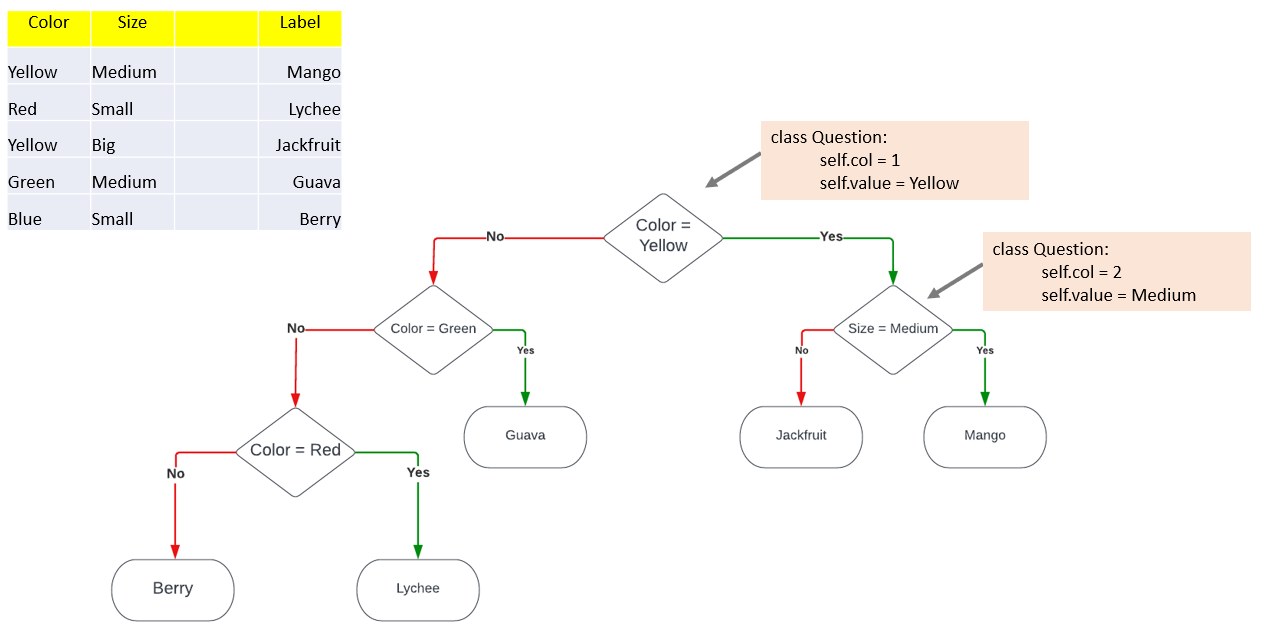

Lets say we have a dataset having 2 columns

Column no1 = Color

Column no2 = Size

Now in the tree, we want to ask a question.
Is the "Size = Medium"?

To store this question as a variable in the program so that we can access it whenever we want and modify it if necessary. We crate a class object.

class Question:

	def __init__(self, col, value):
        self.col = col
        self.value = value

For example,

"Color = Yellow"? >>> Q1 = Question(1, "Yellow")

"Size = Medium"? >>> Q2 = Question(2, "Medium")

In [ ]:
class Question:
    def __init__(self, col, value):
        self.col = col
        self.value = value

    def match(self, row):
        val = row[self.col]
        if isNumeric(val):
            return val >= self.value
        else:
            return val == self.value

    def __repr__(self):
        if isNumeric(self.value):
            condition = '>='
        else:
            condition = '=='
        return "Is %s %s %s?" % (header[self.col], condition, str(self.value))

In [ ]:
class Queue:
    def __init__(self):
        self.buffer = deque()

    def enqueue(self, val):
        self.buffer.appendleft(val)

    def dequeue(self):
        return self.buffer.pop()

    def is_empty(self):
        return len(self.buffer)==0

    def size(self):
        return len(self.buffer)

In [ ]:
def getUnique(rows, col):
    return set([row[col] for row in rows])



def labelCounts(rows):
    counts = {}
    for row in rows:
        label = row[-1]
        if label not in counts:
            counts[label] = 1
        else:
            counts[label] += 1

    return counts



def isNumeric(value):
    return isinstance(value, int) or isinstance(value, float)




def partition(rows, question):
    true_rows, false_rows = [], []
    for row in rows:
        if question.match(row):
            true_rows.append(row)
        else:
            false_rows.append(row)

    return true_rows, false_rows



def gini(rows):
    counts = labelCounts(rows) #counts is dictionary

    impurity = 1
    for label in counts:
        probability = counts[label]/float(len(rows))
        impurity -= (probability * probability)       # 1 - np.sum(p**2)

    return impurity



def informationGain(left, right, currentUncertinity):
    totalLength = len(left) + len(right)
    probability_left = len(left)/float(totalLength)
    probability_right = 1 - probability_left
    weightedGini = (probability_left * gini(left)) + (probability_right * gini(right))
    info_Gain = currentUncertinity - weightedGini
    return info_Gain

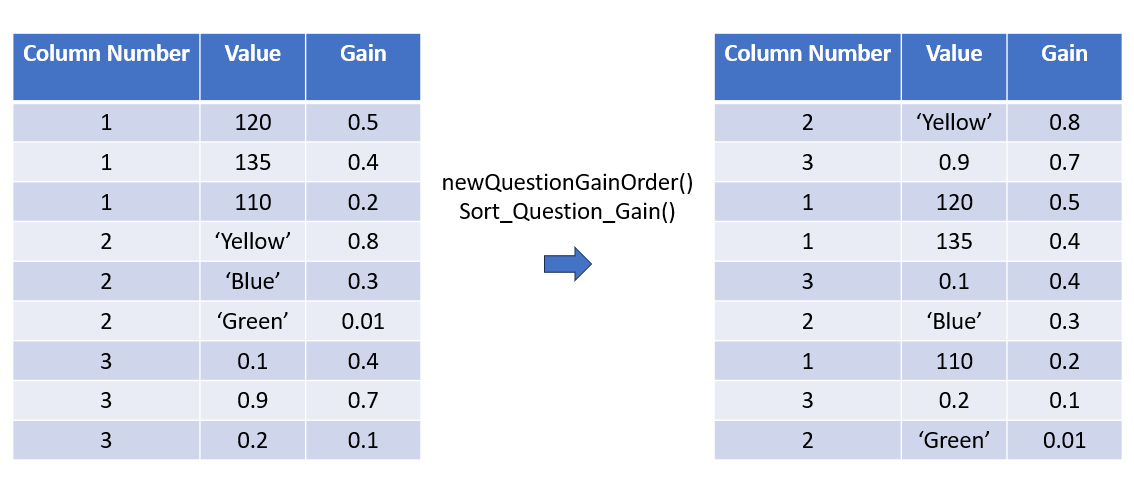

In [ ]:
class Sort_Question_Gain:
    def __init__(self, Q, G):
        self.question = Q
        self.gain = G

    def __repr__(self):
        return self.__str__()

    def __str__(self):
        return "{0}:{1}".format(self.question, self.gain)


def newQuestionGainOrder(all_QuestionGain):
    new_Question_Gain_Order = []
    for Question, Gain in all_QuestionGain:
        new_Question_Gain_Order.append(Sort_Question_Gain(Question, Gain))


    new_Question_Gain_Order = sorted(new_Question_Gain_Order, key=lambda x: x.gain, reverse=True) # sort (Question, gain) objects by gain
    newQG = []
    for class_object in new_Question_Gain_Order:
      newQG.append( (class_object.question, class_object.gain) )

    return newQG

In [ ]:
def findAllSplits(rows):                                                        # Find the best question to ask by iterating over every feature / value and calculating the information gain.
    Question_Gain = []                                                          # This stores all the possible node questions and their correpondent gain value. It helps me to check any verify, if something unexpected/error shows while building the algorithm

    currentUncertinity = gini(rows)
    no_feature = len(rows[0]) - 1                                               # If a row has 5 columns and the last column is label, then total feature no = 5-1

    for col in range(no_feature):                                               # For each feature
        values = set([row[col] for row in rows])                                # Unique values in the column
        for val in values:
            question = Question(col, val)
            trueRows, falseRows = partition(rows, question)                     # Try splitting the dataset

            if ( (len(trueRows) == 0) or (len(falseRows) == 0) ):               # Skip this split if it doesn't divide the dataset.
                continue

            gain = informationGain(trueRows, falseRows, currentUncertinity)     # Calculate the information gain from this split
            Question_Gain.append((question,gain))                               # Here 'questuin' is a Class Object that contains 2 values ( self.col = column_number, self.value = exact_value_in_the_dataset )


    if(len(Question_Gain) >= 1):                                                # If there are more than one possible questions, then find which question has larger gain
        Question_Gain = newQuestionGainOrder(Question_Gain)                            # If i would only use 'len(Question_Gain) > 1', then i had to write another 'else if' statement for 'bestGain', 'bestQuestion' which will actually do the same thing, although that time sorting wouldnt be necessary
        bestQuestion = Question_Gain[0][0]
        bestGain = Question_Gain[0][1]
    else:
        bestQuestion = None                                                     # If there is no possible Question found
        bestGain = 0


    return bestGain, bestQuestion, Question_Gain

### Custom Tree Code

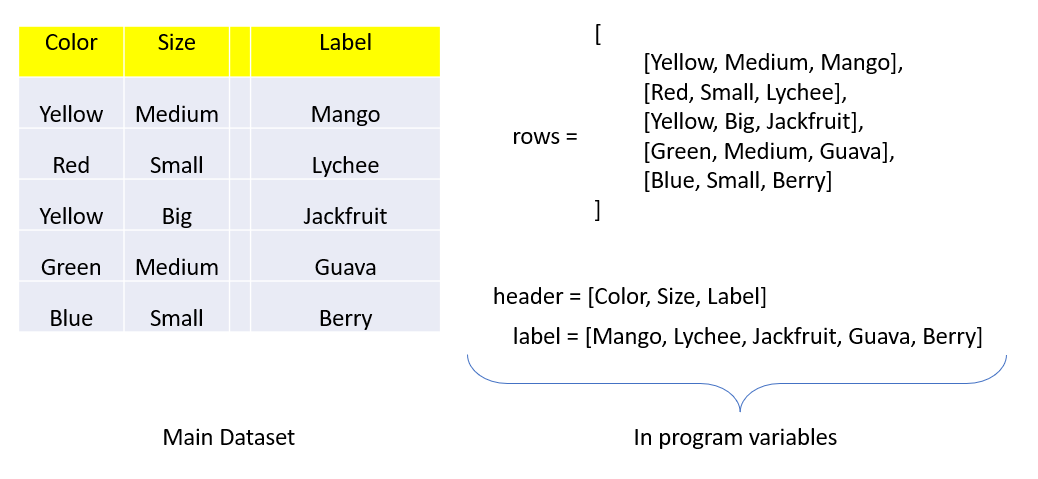

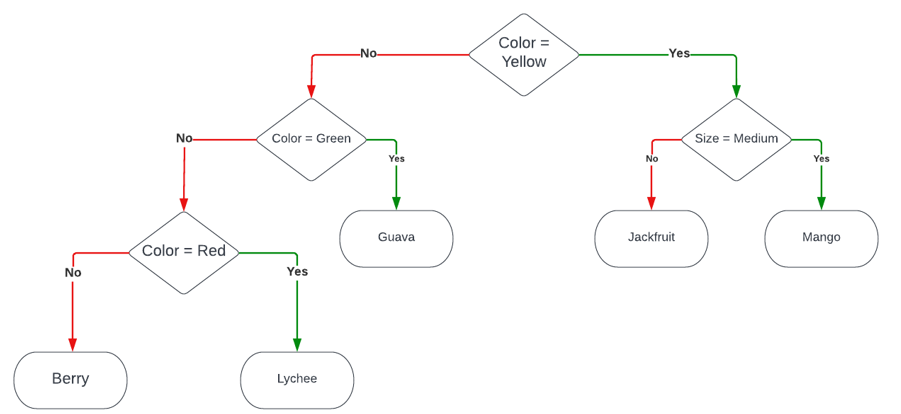

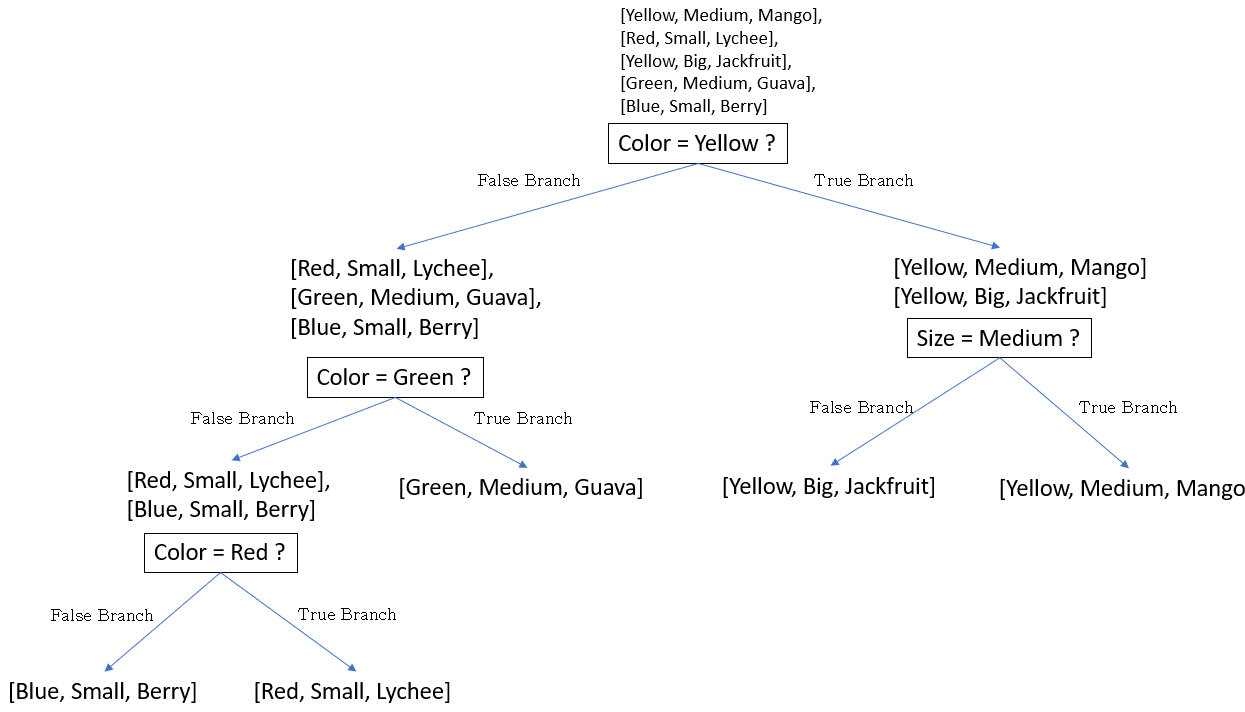

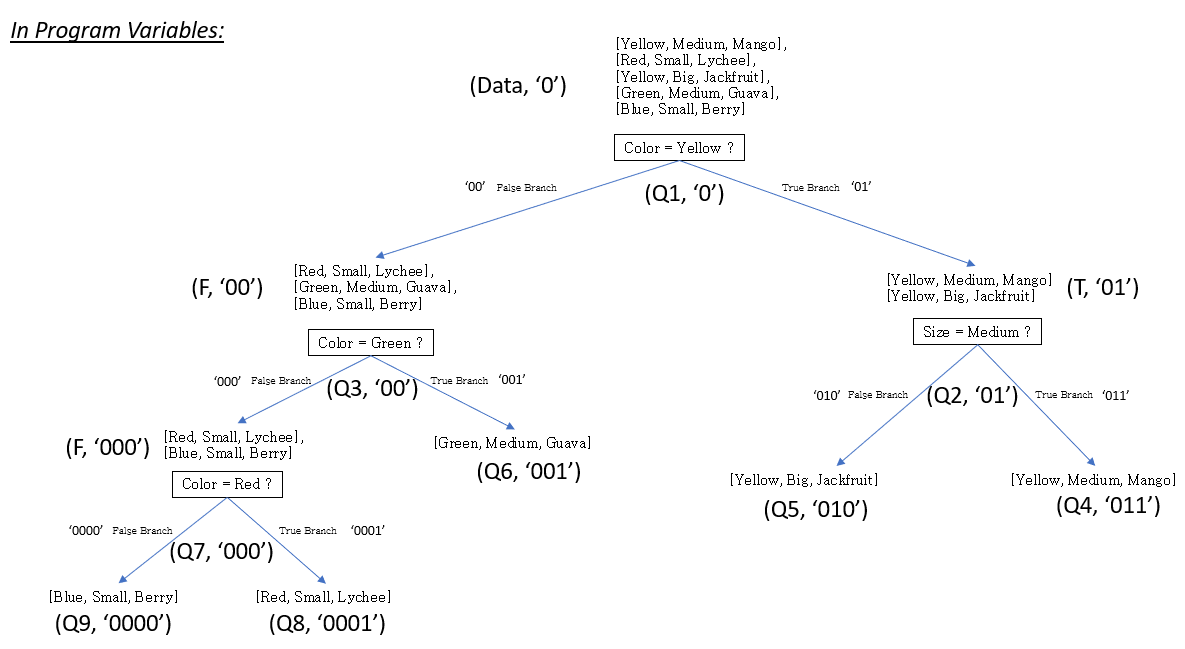

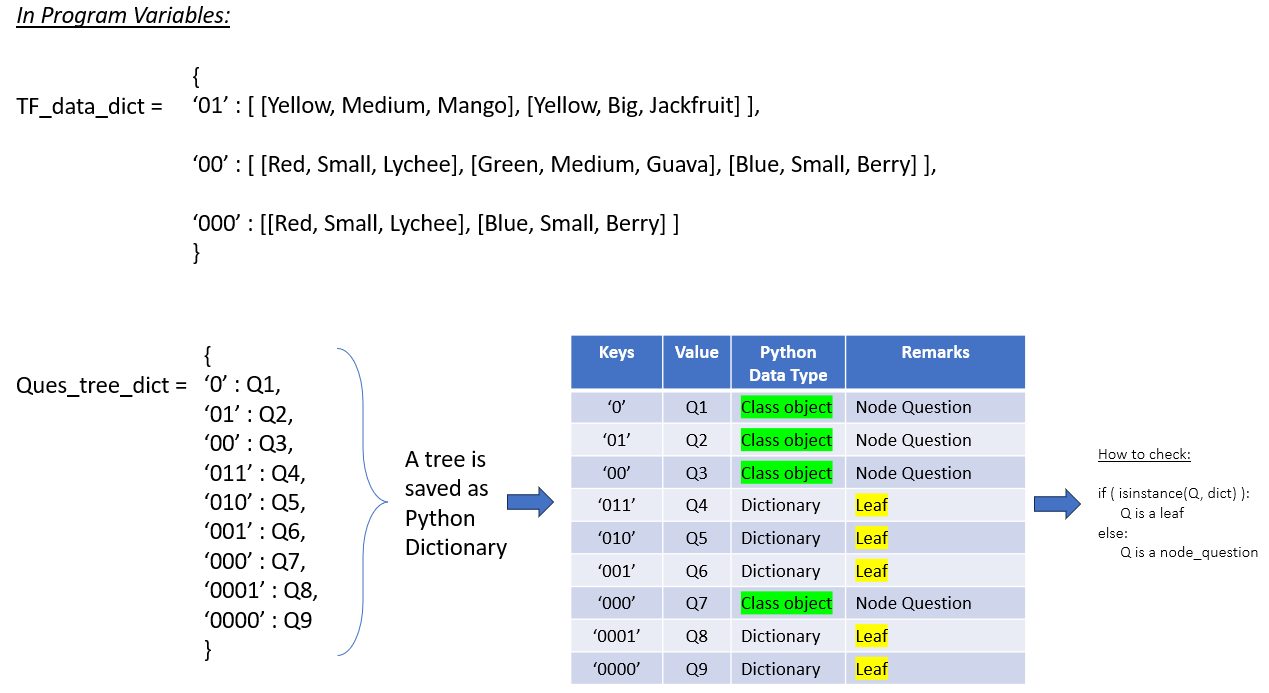

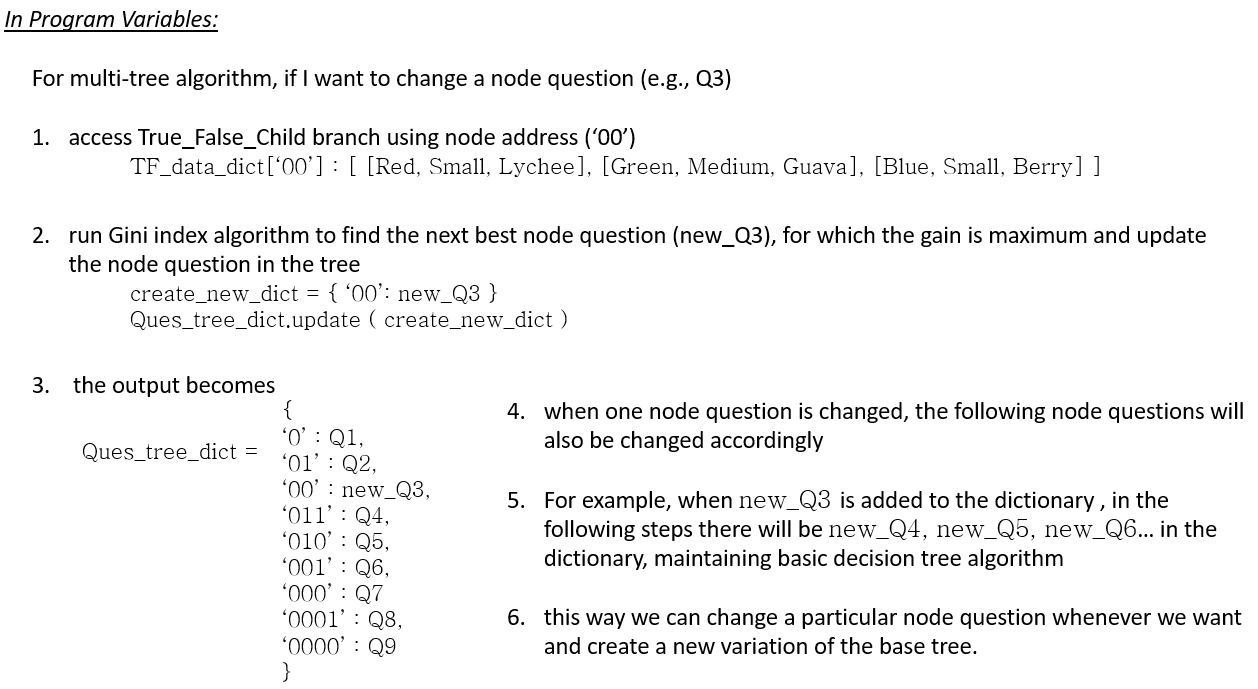

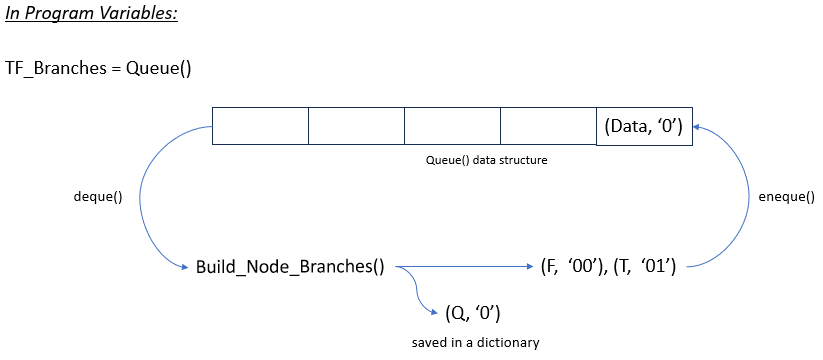

In [ ]:
def buildNodeBranches(rows, Q):
    bestGain, bestQuestion, _ = findAllSplits(rows)            # Finds the node question, for which we get maximum gain, here rows mean available data from which we will calculate max gain and Q is used to forcefully change a Question for Muti-trees
    if (Q != -1):
        bestQuestion = Q


    if (bestGain == 0):                                         # If there is no gain, means no split is possible and we reched to the leaf
        leaf = labelCounts(rows)
        return leaf,[],[]
    else:
        trueRows, falseRows = partition(rows, bestQuestion)     # If a split is possible (gain > 0) then we get 2 child branches
        return bestQuestion, trueRows, falseRows

buildSingleTreeree(data, node, Q):

here,
Data = the rows,

node = the address ( initially its '0' )

Q = is a question that we want to put at a particular node address to create different variations of the same node.


If you see the tree diagram, at the right from center. the node question is "Size=Medium" Now say I want to create a new tree by writing, "Size=Big" at the same place. To find the same place I have used a node address '01'


So in that function,

Q= 'Size=Big'

node='01'


So my function search for a particular node address with  the variable 'node' and when it find the address, change the node Question with 'Q' variable.
After changing one node question I put Q=-1
So that it doesn't change any other question, the tree can be built autonomously following the basic decision tree algorithm.

In [ ]:
def buildSingleTree(data, node, Q):                                # Main function that builts a single tree
    TF_Branches = Queue()
    TF_data_dict = {}
    Ques_tree_dict = {}

    TF_Branches.enqueue( (data, node) )
    while(TF_Branches.is_empty() == False):
        rows, Target_Level = TF_Branches.dequeue()
        Q,T,F = buildNodeBranches(rows, Q)

        if ( (len(T) !=0) and (len(F) !=0) ):                   # len(T)=0, menas we reached to the leaf
            TF_Branches.enqueue( (T, Target_Level+'1') )
            TF_Branches.enqueue( (F, Target_Level+'0') )

            if(len(T)>1):
                TF_data_dict[Target_Level+'1'] = T

            if(len(F)>1):
                TF_data_dict[Target_Level+'0'] = F


        Ques_tree_dict[Target_Level] = Q
        Q = -1                                                 # When one specific node question is changed, used this value to build the rest of tree questions autonomously

    return Ques_tree_dict, TF_data_dict

In [ ]:
class Tree:
    def __init__(self):
        self.Q={}
        self.Data={}

    def Q_dict(self, x):
        self.Q.update(x)
        self.Tree_col_value()

    def TF_Data_dict(self, x):
        self.Data.update(x)

    def Tree_col_value(self):          #node Question = ('node address', column number, value)
        self.Questions_Col_Value=[]
        for key in self.Q.keys():
            if (isinstance(self.Q[key], dict) == False):
                self.Questions_Col_Value.append((key, self.Q[key].col, self.Q[key].value))

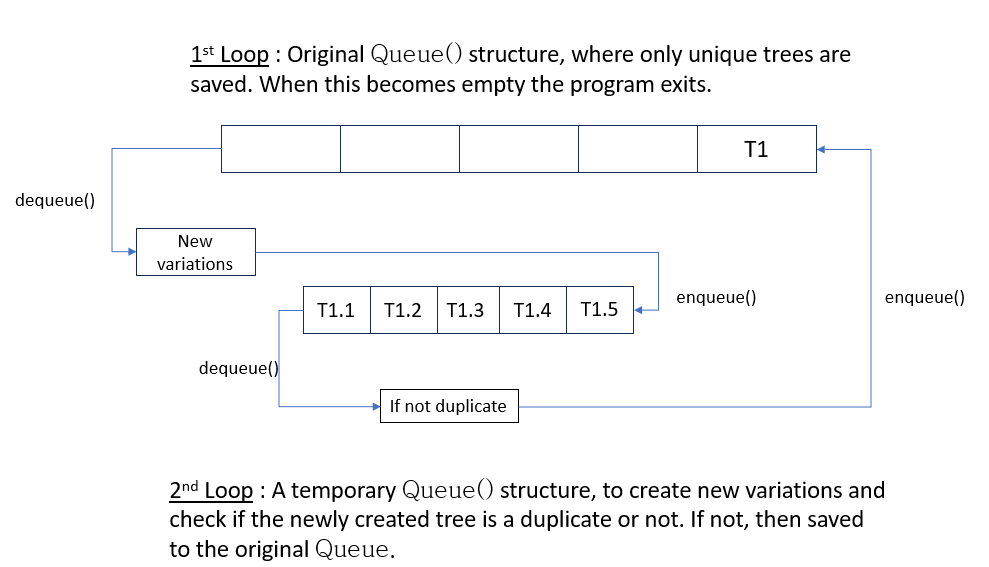

In [ ]:
def buildMultipleTrees(data, dataset_name, L, tree_log):
    allTrees = []                                                                               # All the trees are saved here
    trees_build_complete = False                                                                # When TRUE the program will exit


    t = Tree()                                                                                  # A class object where all the details of a Tree (Questions, Child Branches and other details are saved)
    t.Data['0'] = data
    allTrees.append(t)

    level=1
    while(trees_build_complete == False):
        nTrees = Queue()                                                                        # Used to create more variation of the recently built trees
        new_tree_list = copy.deepcopy(allTrees)                                                 # To duplicate a list and modify it without changing the original one
        new_tree_list.reverse()                                                                 # Reverse the order of the list
        nTrees.buffer.extend(new_tree_list)                                                     # New tree is added for next deque()
        if( len(allTrees) == 1 ):                                                               # First tree is removed from the Queue() to avoid duplicates
            allTrees.remove(allTrees[0])


        while( (nTrees.is_empty() == False) and (trees_build_complete == False)):               # To check if there are any trees avaibale for the dequeue()
            t = nTrees.dequeue()

            all_nodes = list(t.Data.keys())
            target_nodes = [x for x in all_nodes if (len(x)==level)]                            # To change a particular node question
            for node in target_nodes:
                new_data = t.Data[node]
                _, _, Question_Gain = findAllSplits(new_data)

                if(level !=1 ):                                                                 # To avaid the duplicate of Base tree
                    if(isinstance(t.Q[node], dict)):
                        continue
                    else:
                        remove_col = t.Q[node].col
                        remove_val = t.Q[node].value
                        questions = [Q for Q,_ in Question_Gain if ((Q.col, Q.value) != (remove_col, remove_val))]     # Find all the possible question available to replace the current node question

                else:
                    questions = [Q for Q,_ in Question_Gain]

                for q in questions:                                                                                    # Run a loop to change the node question of a particular node
                    new_tree = copy.deepcopy(t)                                                                        # Modify the current tree to create its variations
                    Ques_tree_dict, TF_data_dict, = buildSingleTree( new_data, node, q)                                   # Build the tree
                    new_tree.Q_dict(Ques_tree_dict)                                                                    # Update the current tree dictionary to create a new one
                    new_tree.TF_Data_dict(TF_data_dict)                                                                # Update the current tree dictionary to create a new one

                    duplicate_found = findDuplicateTree(allTrees, new_tree)                                            # To avoid saving the same tree

                    if (duplicate_found == False):
                      nTrees.enqueue(new_tree)                                                                         # When a tree passes the validation, it is added to immediately create its other variations
                      allTrees.append(new_tree)                                                                        # When a tree passes the validation, it is saved

                      if( len(allTrees) % tree_log == 0):                                                              # Message to print during training, to monitor perogress
                        output.clear()
                        print('\nRunning Dataset--------->>>>>--- ', dataset_name, ' -------->>>>>----\n')
                        print('Total Tree Created:', len(allTrees), '    Max_L:', L, '\n\n')


                      if (len(allTrees)==L):                                                                           # When number of trees built reached L, the program exit()
                          trees_build_complete = True
                          break

                if(trees_build_complete == True):
                    break

            if(level==1):
                break


        if (len(target_nodes)==0):
            trees_build_complete == True
            break

        level += 1

    if (len(allTrees)<L):                                                                                              # Its possible that all the trees saved less than L (e.g., only 500/1000(L) trees can be created)
      print('Maximum Tree Build Reached : ', len(allTrees))

    return allTrees

In [ ]:
#Finds any duplicate in the list of all trees that built so far
def findDuplicateTree(allTrees, newTree):
    duplicate_status = False
    for existing_tree in allTrees:
        if (existing_tree.Questions_Col_Value == newTree.Questions_Col_Value):   # Checks if the dictionary values of the newTree matches with all the previoulsy saved Tress
            duplicate_status = True
            break

    return duplicate_status

In [ ]:
#A class object which will be used to sort Trees based on Validation accuracy
class Sort_Trees_valAcc:
    def __init__(self, T, V):
        self.tree = T
        self.val_acc = V

    def __repr__(self):
        return self.__str__()

    def __str__(self):
        return "{0}:{1}".format(self.tree, self.val_acc)


#A function that is used to sort the trees according to their validation accuracy
def Tree_ValAcc_Sort(tree, valAcc):
    tree_valAcc_classList = []

    for i in range(len(tree)) :
        tree_valAcc_classList.append(Sort_Trees_valAcc(tree[i], valAcc[i]))

    tree_valAcc_classOrder = sorted(tree_valAcc_classList, key=lambda x: x.val_acc, reverse=True) # sort (Tree, valAcc) objects by valAcc
    trees_sorted = []
    valAcc_sorted = []
    for class_object in tree_valAcc_classOrder:
      trees_sorted.append(class_object.tree)
      valAcc_sorted.append(class_object.val_acc)

    return trees_sorted, valAcc_sorted


#After building L number of trees, this function filters and choose K number of trees that satisfy the given condintions in terms of accuracy tollerance and average of previously built all trees
def multiTreeFilter(allTrees, X_validation, Y_validation, dataset_name, accuracy_tollerance, K):
  validation_passed_trees=[]
  validation_acc_list=[]
  avg_val_acc = 0

  i=1                                                                           # initialization to count first 3 trees
  for tree in allTrees:                                                         # find the validation accuracy of all L number of trees
    y_pred = predict(X_validation, tree)
    val_accuracy = accuracy_score(Y_validation, y_pred)
    if (i<4):
      validation_passed_trees.append(tree)                                      # no objection to save first 3 trees
      validation_acc_list.append(val_accuracy)                                  # save first 3 validation accuracy
      i+=1
    else:
      avg_val_acc = sum(validation_acc_list)/len(validation_acc_list)           # start calculating the average accuracy from 4th trees of the L number of trees
      min_required_accuracy = avg_val_acc*accuracy_tollerance                   # if tollerance=0.9 and avg_acc=0.6 >>> min_acc required = 0.6*0.9 =0.54
      if (val_accuracy > min_required_accuracy):                                         # if the tree passes required validation accuracy, save it
        validation_passed_trees.append(tree)
        validation_acc_list.append(val_accuracy)

  # in this stage we have saved those trees from L number of trees which passes the minimum required validation accuracy
  # now we have to sort the final trees and choose first K number of trees that has best validation accuracy
  # for example say, L=1000 and trees that passes the minimum validation accuracy = 600, but we decided K=100
  # so first sort this final 600 trees based on their validation accuracy and then only return the first K=100 trees and their respective validation accuracy from this function
  print('Validation Passed:', len(validation_passed_trees), ' Average Validation Accuracy:', avg_val_acc, '\n\n')

  validation_passed_trees_sorted, valAcc_sorted = Tree_ValAcc_Sort(validation_passed_trees, validation_acc_list)
  finalTrees = validation_passed_trees_sorted[:K]
  return finalTrees

In [ ]:
#Print a custom build tree in traditional way
def displayTree(a_dict, spacing='', Target_Level='0'):
    ques = a_dict[Target_Level]

    if(isinstance(ques, dict)):
        print(spacing + '|--predict: ', ques)
        return

    spacing += '|---'
    print(spacing, ques)
    print(spacing + '|>True')
    displayTree(a_dict, spacing, Target_Level+'1')

    print(spacing + '|>False')
    displayTree(a_dict, spacing, Target_Level+'0')

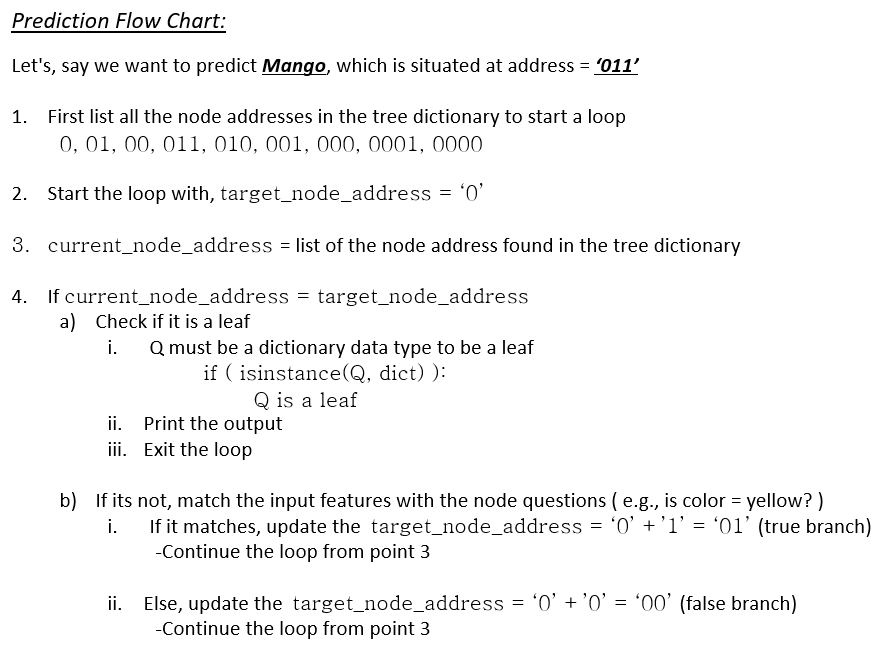

In [ ]:
#Gives Output when a tree and input features are given
def predict(features, tree):
    tree = tree.Q

    # features must have one row (eg. features = [[ , , , , ]])
    # to avoid the error we used try and Exception

    features_to_array = array (features)
    features_to_array_dim = features_to_array.shape
    try:
      features_to_array_dim[1]
    except IndexError:
      return print("Sorry, Features Must Contain Minimum One Dimension, eg. features = [ [ , , , , ] ] ")

    y_pred = []

    for feature in features:
      target_node = '0'
      for node in tree.keys():
          if (node==target_node):
              if(isinstance(tree[node], dict)):
                  prediction =  list(tree[node].keys())
                  y_pred.append(prediction[0])
              else:
                  if (tree[node].match(feature)):
                      target_node = node + '1'
                  else:
                      target_node = node + '0'


    return y_pred

In [ ]:
class muultiTreeAlgorithm:
    def __init__(self):
        pass


    def addXY(self):                                                                                                      # adds X (features) and Y (labels) to represent as rows
        self.data = []
        for i in range(len(self.X_train)):
            row = []
            row.extend(self.X_train[i])
            row.append(self.Y_train[i])
            self.data.append(row)


    def build(self, X_train, Y_train, dataset_name, max_L, tree_log):
      self.X_train = X_train
      self.Y_train = Y_train
      self.addXY()
      self.allTrees = buildMultipleTrees(self.data, dataset_name, max_L, tree_log)


    def finalValidationAndTesting(self, X_validation, Y_validation, X_test, Y_test, dataset_name, accuracy_tollerance_list, L_list, K_list):
      single_row_dataFrame=[]

      if (len(self.allTrees) < max(L_list)):
        return 'Parameter Tuning Failed: Total tree created is less than maximum value of L'
      elif (max(L_list) < max(K_list)):
        return 'Parameter Tuning Failed: Maximum value of L is less than maximum value of K'

      for L in L_list:
        for K in K_list:
          for accuracy_tollerance in accuracy_tollerance_list:
            output.clear()
            print('Running Parameter Tuning for Dataset ----->>>>>---', dataset_name, ' ----->>>>>---\nAccuracy Tollerance:',  accuracy_tollerance, ' Value of L:', L, ' Value of K:', K, '\n\n')

            self.finalTrees = multiTreeFilter(self.allTrees[:L], X_validation, Y_validation, dataset_name, accuracy_tollerance, K)
            acc_precision_recall_f1 = self.majorityVoteScores(X_test, Y_test)

            temp_list = [L, K, accuracy_tollerance]
            temp_list.extend(acc_precision_recall_f1)
            single_row_dataFrame.append(temp_list)

      df = pd.DataFrame(single_row_dataFrame)
      df.columns = ['L', 'K', 'Tollerance', 'Acc', 'Precision', 'Recall', 'F1']
      return df                                                                 # result after all parameter tuning for one dataset


    def print(self, tree_no=0):
      if (tree_no==0):
        i=1
        for tree in self.finalTrees:
          print('----------- Tree No', i, '------------\n')
          displayTree(tree.Q)
          print('\n')
          i+=1
      else:
          displayTree(self.finalTrees[tree_no-1].Q)


    def majorityVoteScores(self, X_test, Y_test):                                                                       # For same feature how many trees gave the same prediction
      majority_pred = []
      for single_row_input in X_test:
        Tree_pred = []

        for tree in self.finalTrees:
          pred = predict([single_row_input], tree)
          Tree_pred.append(pred)

        majority_pred.append(max(Tree_pred, key=Tree_pred.count))

      return performanceReport(Y_test, majority_pred)


### Analysis

In [ ]:
def performanceReport(y_test, y_pred, label_names=[], index=[], columns=[]):
  cMatrix = confusion_matrix(y_test, y_pred)
  if ( (len(index) > 0) and (len(columns) > 0) ):
      cm_df = pd.DataFrame(cMatrix, index, columns)

      plt.figure(figsize=(5,4))
      sns.heatmap(cm_df, annot=True)
      plt.title('Confusion Matrix')
      plt.ylabel('Actal Values')
      plt.xlabel('predicted Values')
      plt.show()

  if ( len(label_names) > 0 ):
      print(classification_report(y_test, y_pred, target_names=label_names))

  results = [accuracy_score(y_test, y_pred)]
  prcision_rcall_f1_support = list(precision_recall_fscore_support(y_test, y_pred, average='macro'))

  prcision_rcall_f1 = prcision_rcall_f1_support[:3]
  results.extend(prcision_rcall_f1)
  results = [round(x,3) for x in results]
  return results #---> [acc, precision, recall, f1]

In [ ]:
def listGraphPlot(list_to_be_plotted, title="Accuracy Graph", x_label="No of Trees", y_label="Accuracy"):
  x_axis = list(range(1, len(list_to_be_plotted)+1))
  plt.title(title)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.plot(x_axis,list_to_be_plotted)
  plt.savefig(title+'.png', bbox_inches='tight')
  plt.show()

  #print("First value:", list_to_be_plotted[0])
  #print("Last value:", list_to_be_plotted[-1])

### Datasets

In [ ]:
def binaryPartition(X, header):
    header = header[:-1]
    df = pd.DataFrame(X, columns = header)

    frames = []
    for i in range(len(header)):
      col = header[i]
      df_one = pd.get_dummies(df[col], prefix=col)
      header_temp = list(df_one)
      df_temp = np.where(df_one==0,0.1,0.0)
      df_one = pd.DataFrame(df_temp, columns = header_temp)
      frames.append(df_one)

    result = pd.concat(frames, axis=1, join='inner')
    header = list(result)
    header.append('Label')
    X = result.values.tolist()
    return X, header


In [ ]:
dataset_path = '/content/drive/MyDrive/Colab/Decision Tree/Datasets/Datasets/Pickle Formats/'

public_dataset_names = ['Cancer', 'Diabetics', 'Heart', 'Titanic', 'Netflix', 'CountrySalary', 'Psycology','Housing', 'CreditRisk', 'CarAccept']
synthetic_dataset_names =['Dim_low', 'Dim_moderate', 'Dim_high', 'Noise_low', 'Noise_moderate', 'Noise_high', 'Outlier_low', 'Outlier_moderate', 'Outlier_high']

#names = synthetic_dataset_names
#file_prefix = 'Synthetic_'     # used to save file

names = public_dataset_names
file_prefix = 'Public_'

def Datasets(name):
  with open(dataset_path + name + '.pkl', 'rb') as f:
    data = pickle.load(f)

  return data['X_train'], data['X_validation'], data['X_test'], data['Y_train'], data['Y_validation'], data['Y_test'], data['header'], data['label_names']

### Main Code

In [ ]:
saving_path = '/content/drive/MyDrive/Colab/Decision Tree/ExcelResults/'

### MAJORITY VOTING (Training)

In [ ]:
datasets_result = []

L = [500, 1000, 1500, 2000, 2500]
K = [100, 200, 300]

accuracy_tollerance = [0.95, 0.85, 0.75]
tree_log = 10                                                                                                              # No of trees after which progress will print

datasets_no = [0,1]

for i in datasets_no:
  dataset_name = names[i]                                                                                                          # To slect a particular dataset for training
  X_train, X_validation, X_test, Y_train, Y_validation, Y_test, header, label_names = Datasets(dataset_name)

  myTree = muultiTreeAlgorithm()
  myTree.build(X_train, Y_train, dataset_name, max(L), tree_log)

  df = myTree.finalValidationAndTesting(X_validation, Y_validation, X_test, Y_test, dataset_name, accuracy_tollerance, L, K)
  datasets_result.append(df)
  df.to_excel(saving_path + 'MajorityVoting/'+ file_prefix + dataset_name + '_MajorityVoting.xlsx', sheet_name= dataset_name)


with pd.ExcelWriter(saving_path + 'MajorityVoting/' + file_prefix + 'MajorityVoting.xlsx') as writer:
  j=0
  for i in datasets_no:
    datasets_result[j].to_excel(writer, sheet_name= dataset_name)
    j+=1

Running Parameter Tuning for Dataset ----->>>>>--- CountrySalary  ----->>>>>---
Accuracy Tollerance: 0.95  Value of L: 2500  Value of K: 200 




In [ ]:
values = []
rows_name=[]
for name in names:
  file = saving_path + 'MajorityVoting/' + file_prefix + name + '_MajorityVoting.xlsx'
  df = pd.read_excel(file)
  value = df['Acc'].max()
  values.append(float(value))
  rows_name.append(name)

df_majority = pd.DataFrame(values, index=rows_name, columns=['Majority_Vote'])
df_majority



,Majority_Vote
Cancer,0.965
Diabetics,0.857
Heart,0.742
Titanic,0.685
Netflix,0.800
CountrySalary,0.594
Psycology,1.000
Housing,0.400
CreditRisk,0.800
CarAccept,0.954


### Best Accuracy From Majority Voting

In [ ]:
#Merge all datframe into single dataframe
df_list = []
for name in names:
  df = pd.read_excel(saving_path + 'MajorityVoting/' + file_prefix +  name + '_MajorityVoting.xlsx')
  df = df.drop(df.columns[[0]], axis=1)
  df.sheet_name = name
  df_list.append(df)

# Specify the output file name
output_file = saving_path + file_prefix +  'MajorityVoting.xlsx'

# Create an Excel writer
with pd.ExcelWriter(output_file) as writer:
    # Add each DataFrame to the writer with a sheet name
    for df in df_list:
      df.to_excel(writer, sheet_name=df.sheet_name, index=False)

In [ ]:
file = saving_path + file_prefix + 'MajorityVoting.xlsx'
df_list = []

K_list = [100,200,300]
L_list = [500,1000,1500,2000,2500]

for name in names:
  df = pd.read_excel(file, sheet_name=name)
  single_row_dataFrame = []
  for L in L_list:
    for K in K_list:
      acc = float(df.loc[(df['L']==L) & (df['K']==K) & (df['Tollerance']==0.95), 'Acc'])
      precision = float(df.loc[(df['L']==L) & (df['K']==K) & (df['Tollerance']==0.95), 'Precision'])
      recall = float(df.loc[(df['L']==L) & (df['K']==K) & (df['Tollerance']==0.95), 'Recall'])
      f1 = float(df.loc[(df['L']==L) & (df['K']==K) & (df['Tollerance']==0.95), 'F1'])


      single_row_dataFrame.append([L, K, acc, precision, recall, f1])

  df = pd.DataFrame(single_row_dataFrame)
  df.columns = ['L', 'K', 'Acc', 'Precision', 'Recall', 'F1']
  df = df.reset_index()
  x = df.loc[df['Acc'].idxmax()]
  x = list(x)
  df_list.append([x[3],x[4], x[5], x[6], x[2], x[1]])


df_BestMajorityVoting = pd.DataFrame(df_list)
df_BestMajorityVoting.columns = ['Acc', 'Precision', 'Recall', 'F1', 'K', 'L']
df_BestMajorityVoting.index = names

df_BestMajorityVoting.to_excel(saving_path + file_prefix + 'Best_Majority_Voting.xlsx')

df_BestMajorityVoting

<ipython-input-31-0b96128ea5f1>:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  acc = float(df.loc[(df['L']==L) & (df['K']==K) & (df['Tollerance']==0.95), 'Acc'])
<ipython-input-31-0b96128ea5f1>:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  precision = float(df.loc[(df['L']==L) & (df['K']==K) & (df['Tollerance']==0.95), 'Precision'])
<ipython-input-31-0b96128ea5f1>:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  recall = float(df.loc[(df['L']==L) & (df['K']==K) & (df['Tollerance']==0.95), 'Recall'])
<ipython-input-31-0b96128ea5f1>:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  f1 = floa

,Acc,Precision,Recall,F1,K,L
Cancer,0.965,0.957,0.972,0.963,300.0,500.0
Diabetics,0.857,0.842,0.864,0.849,300.0,1000.0
Heart,0.742,0.739,0.739,0.739,100.0,2000.0
Titanic,0.685,0.665,0.661,0.663,100.0,500.0
Netflix,0.800,0.765,0.743,0.752,300.0,500.0
CountrySalary,0.594,0.595,0.594,0.594,300.0,1500.0
Psycology,1.000,1.000,1.000,1.000,100.0,500.0
Housing,0.400,0.386,0.379,0.382,200.0,500.0
CreditRisk,0.800,0.765,0.743,0.752,300.0,500.0
CarAccept,0.954,0.861,0.903,0.874,100.0,2500.0


### Plot L and K vs Accuracy

In [ ]:
file = saving_path + file_prefix +  'MajorityVoting.xlsx'

K_list = [100, 200, 300]
L_list = [500,1000,1500,2000,2500]

df_list = []

for name in names:
  df = pd.read_excel(file, sheet_name=name)
  single_row_dataFrame = []
  for L in L_list:
    for K in K_list:
      acc = float(df.loc[(df['L']==L) & (df['K']==K) & (df['Tollerance']==0.95), 'Acc'])
      single_row_dataFrame.append([L, K, acc])

  df = pd.DataFrame(single_row_dataFrame)
  df.columns = ['L', 'K', name]
  df_list.append(df)


df = df_list[0]
for i in range(1,8):
  df = pd.concat([df, df_list[i][names[i]]],axis = 1)

df

<ipython-input-8-402277214bae>:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  acc = float(df.loc[(df['L']==L) & (df['K']==K) & (df['Tollerance']==0.95), 'Acc'])
<ipython-input-8-402277214bae>:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  acc = float(df.loc[(df['L']==L) & (df['K']==K) & (df['Tollerance']==0.95), 'Acc'])
<ipython-input-8-402277214bae>:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  acc = float(df.loc[(df['L']==L) & (df['K']==K) & (df['Tollerance']==0.95), 'Acc'])
<ipython-input-8-402277214bae>:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  acc = float(df.loc[(df['L']==L)

,L,K,Diabetics,Heart,Titanic,Netflix,Psycology,Housing,CreditRisk,CarAccept
0,500,100,0.792,0.677,0.685,0.74,1.0,0.382,0.74,0.948
1,500,200,0.831,0.645,0.674,0.77,1.0,0.400,0.77,0.942
2,500,300,0.818,0.645,0.674,0.80,1.0,0.382,0.80,0.942
3,1000,100,0.805,0.645,0.685,0.77,1.0,0.400,0.77,0.942
4,1000,200,0.831,0.645,0.685,0.78,1.0,0.382,0.78,0.942
5,1000,300,0.857,0.645,0.685,0.78,1.0,0.382,0.78,0.942
6,1500,100,0.805,0.710,0.685,0.76,1.0,0.400,0.76,0.948
7,1500,200,0.831,0.710,0.685,0.80,1.0,0.382,0.80,0.948
8,1500,300,0.831,0.677,0.685,0.80,1.0,0.382,0.80,0.948
9,2000,100,0.805,0.742,0.685,0.76,1.0,0.400,0.76,0.948


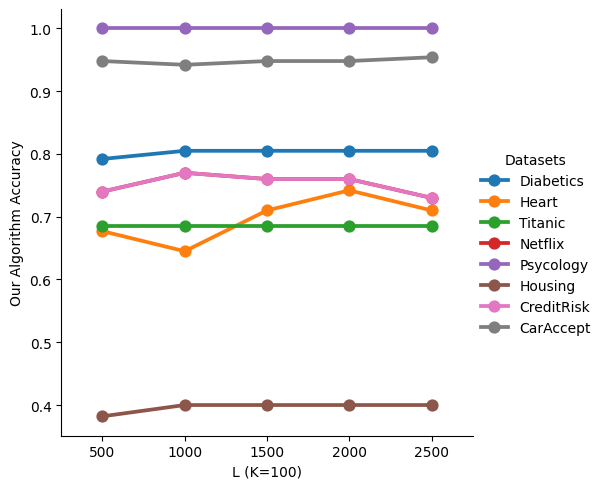

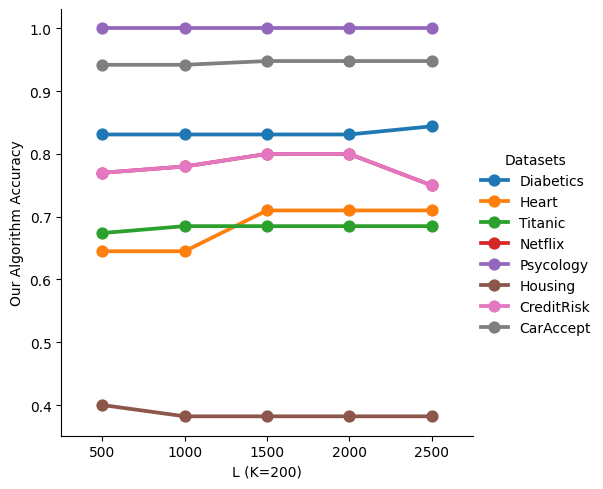

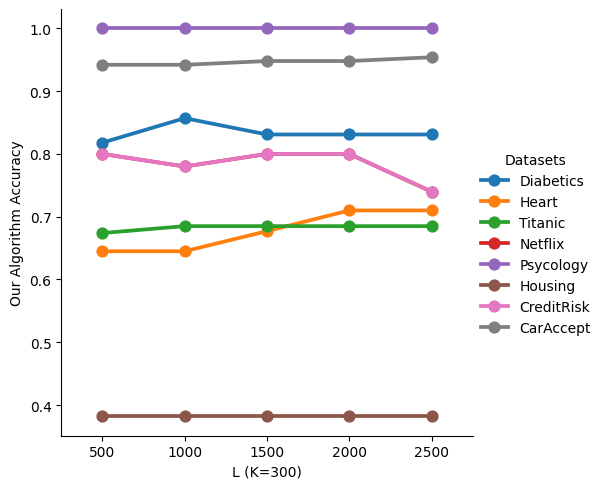

In [ ]:
pic_name = 1
for K in K_list:
  i=K
  df_new = df.loc[df['K']==i]
  df_new = df_new.loc[ : , df.columns != 'K']

  new_X_axiss_name = 'L (K='+str(i) +')'
  df_new.rename(columns = {'L':new_X_axiss_name}, inplace = True)

  dfm = df_new.melt(new_X_axiss_name, var_name='Datasets', value_name='Our Algorithm Accuracy')
  g = sns.catplot(x=new_X_axiss_name, y="Our Algorithm Accuracy", hue='Datasets', data=dfm, kind='point')
  fig_name = file_prefix + "L vs Acc (K Fixed)"+ str(pic_name) +".png"
  g.figure.savefig(saving_path + 'L and K vs Accuracy Plot/' + fig_name)
  pic_name+=1
  print('\n\n')

In [ ]:
dfs = []
for K in K_list:
  i=K
  df_new = df.loc[df['K']==i]
  df_new = df_new.loc[ : , df.columns != 'K']
  print(K)
  dfs.append(df_new)

dfs[0]

100
200
300


,L,Diabetics,Heart,Titanic,Netflix,Psycology,Housing,CreditRisk,CarAccept
0,500,0.792,0.677,0.685,0.74,1.0,0.382,0.74,0.948
3,1000,0.805,0.645,0.685,0.77,1.0,0.400,0.77,0.942
6,1500,0.805,0.710,0.685,0.76,1.0,0.400,0.76,0.948
9,2000,0.805,0.742,0.685,0.76,1.0,0.400,0.76,0.948
12,2500,0.805,0.710,0.685,0.73,1.0,0.400,0.73,0.954


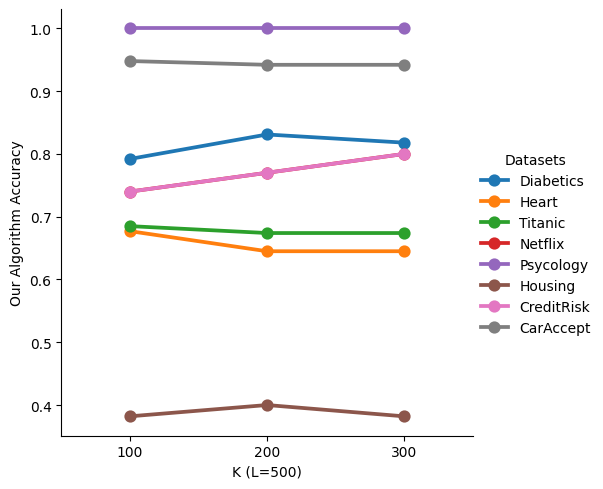

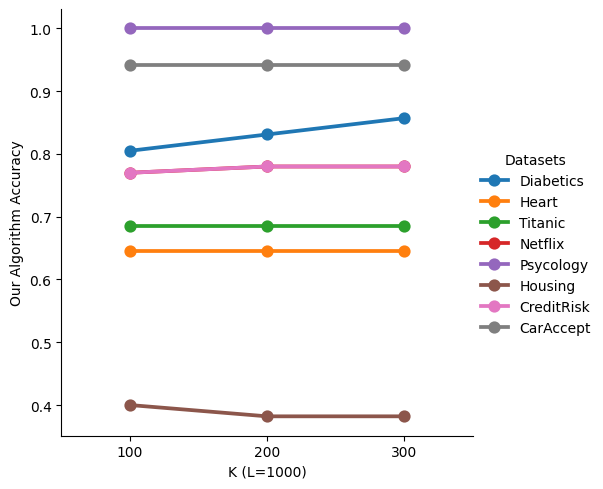

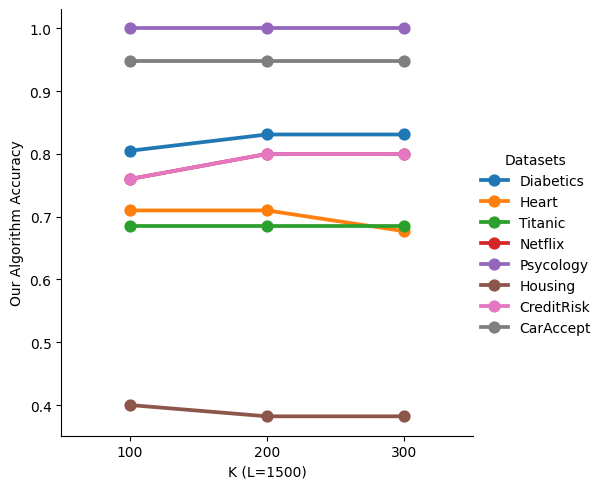

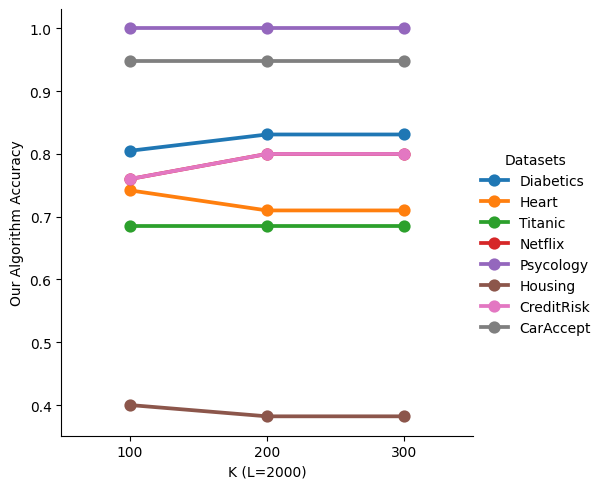

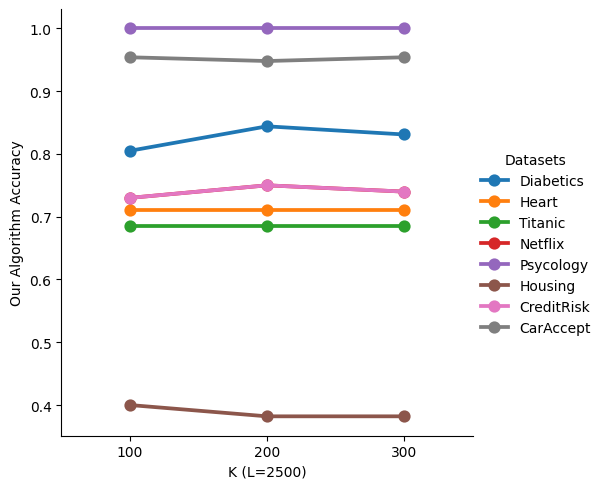

In [ ]:
pic_name = 1
for L in L_list:
  i=L
  df_new = df.loc[df['L']==i]
  df_new = df_new.loc[ : , df.columns != 'L']

  new_X_axiss_name = 'K (L='+str(i) +')'
  df_new.rename(columns = {'K':new_X_axiss_name}, inplace = True)

  dfm = df_new.melt(new_X_axiss_name, var_name='Datasets', value_name='Our Algorithm Accuracy')
  g = sns.catplot(x=new_X_axiss_name, y="Our Algorithm Accuracy", hue='Datasets', data=dfm, kind='point')
  fig_name = file_prefix + "K vs Acc (L Fixed)"+ str(pic_name) +".png"
  g.figure.savefig(saving_path + 'L and K vs Accuracy Plot/' + fig_name)
  pic_name+=1
  print('\n\n')

### Other Models (Training)

https://www.kaggle.com/code/vbmokin/titanic-0-83253-comparison-20-popular-models#kln-8

In [ ]:
columns = ['DatasetName', 'KNN', 'DecessionTress', 'RandomForest', 'BaggingClassifier', 'XGB', 'Gradient Boost', 'ExtraTrees' ]

df_acc_result = []
df_precsion_result = []
df_recall_result = []
df_f1_result = []

for i in range(len(names)):
  X_train, X_validation, X_test, Y_train, Y_validation, Y_test, header, label_names = Datasets(names[i])
  dset_name = names[i]
  print(f'\nRunning Dataset-->>>>>---- {i+1} of {len(names)} --->>>>> {dset_name}')

  single_row_df_acc = [dset_name]
  single_row_df_precsion = [dset_name]
  single_row_df_recall = [dset_name]
  single_row_df_f1 = [dset_name]

  knn = GridSearchCV(estimator=KNeighborsClassifier(), param_grid={'n_neighbors': [2, 3, 4]}, cv=cv_number).fit(X_train, Y_train)

  Y_pred = knn.predict(X_test)
  results = performanceReport(Y_test, Y_pred)
  single_row_df_acc.append(results[0])
  single_row_df_precsion.append(results[1])
  single_row_df_recall.append(results[2])
  single_row_df_f1.append(results[3])


  decision_tree = DecisionTreeClassifier()
  decision_tree.fit(X_train, Y_train)
  Y_pred = decision_tree.predict(X_test).astype(int)
  results = performanceReport(Y_test, Y_pred)
  single_row_df_acc.append(results[0])
  single_row_df_precsion.append(results[1])
  single_row_df_recall.append(results[2])
  single_row_df_f1.append(results[3])


  random_forest = GridSearchCV(estimator=RandomForestClassifier(), param_grid={'n_estimators': [200, 300, 400, 500]}, cv=5).fit(X_train, Y_train)
  random_forest.fit(X_train, Y_train)
  Y_pred = random_forest.predict(X_test).astype(int)
  results = performanceReport(Y_test, Y_pred)
  single_row_df_acc.append(results[0])
  single_row_df_precsion.append(results[1])
  single_row_df_recall.append(results[2])
  single_row_df_f1.append(results[3])


  bagging_classifier = BaggingClassifier()
  bagging_classifier.fit(X_train, Y_train)
  Y_pred = bagging_classifier.predict(X_test).astype(int)
  results = performanceReport(Y_test, Y_pred)
  single_row_df_acc.append(results[0])
  single_row_df_precsion.append(results[1])
  single_row_df_recall.append(results[2])
  single_row_df_f1.append(results[3])


 ##==============================================================================
  my_model = xgb.XGBClassifier()
  my_model.fit(X_train, Y_train)

  # Predicting the Test set results
  Y_pred = my_model.predict(X_test)
  output.clear()
  results = performanceReport(Y_test, Y_pred)
  single_row_df_acc.append(results[0])
  single_row_df_precsion.append(results[1])
  single_row_df_recall.append(results[2])
  single_row_df_f1.append(results[3])


 ##==============================================================================
  gbc = GradientBoostingClassifier(n_estimators=300,
                                  learning_rate=0.05,
                                  random_state=100,
                                  max_features=5 )
  gbc.fit(X_train, Y_train)
  Y_pred = gbc.predict(X_test).astype(int)
  output.clear()
  results = performanceReport(Y_test, Y_pred)
  single_row_df_acc.append(results[0])
  single_row_df_precsion.append(results[1])
  single_row_df_recall.append(results[2])
  single_row_df_f1.append(results[3])

 ##==============================================================================
  model = ExtraTreesClassifier()
  model.fit(X_train, Y_train)
  Y_pred = model.predict(X_test)
  results = performanceReport(Y_test, Y_pred)
  single_row_df_acc.append(results[0])
  single_row_df_precsion.append(results[1])
  single_row_df_recall.append(results[2])
  single_row_df_f1.append(results[3])

 ################################################################################
  df_acc = pd.DataFrame([single_row_df_acc])
  df_acc.columns = columns
  df_acc_result.append(df_acc)

  df_precsion = pd.DataFrame([single_row_df_precsion])
  df_precsion.columns = columns
  df_precsion_result.append(df_precsion)

  df_recall = pd.DataFrame([single_row_df_recall])
  df_recall.columns = columns
  df_recall_result.append(df_recall)

  df_f1 = pd.DataFrame([single_row_df_f1])
  df_f1.columns = columns
  df_f1_result.append(df_f1)


df_other_acc = pd.concat(df_acc_result)
df_other_acc.index = names
df_other_acc.to_excel(saving_path + file_prefix + 'Other_Models_acc.xlsx')

df_other_precsion = pd.concat(df_precsion_result)
df_other_precsion.index = names
df_other_precsion.to_excel(saving_path + file_prefix + 'Other_Models_precision.xlsx')

df_other_recall = pd.concat(df_recall_result)
df_other_recall.index = names
df_other_recall.to_excel(saving_path + file_prefix + 'Other_Models_recall.xlsx')

df_other_f1 = pd.concat(df_f1_result)
df_other_f1.index = names
df_other_f1.to_excel(saving_path + file_prefix + 'Other_Models_f1.xlsx')

### Final Results

In [ ]:
#Merge all datframe into single dataframe
df_list = []
for metric in ['acc', 'precision', 'recall', 'f1']:
  df = pd.read_excel(saving_path + file_prefix + 'Other_Models_' + metric + '.xlsx')
  df.sheet_name = metric
  df_list.append(df)

# Specify the output file name
output_file = saving_path + file_prefix + 'OtherModels.xlsx'

# Create an Excel writer
with pd.ExcelWriter(output_file) as writer:
    # Add each DataFrame to the writer with a sheet name
    for df in df_list:
      df.to_excel(writer, sheet_name=df.sheet_name, index=False)

In [30]:
from IPython.display import display
for metric in ['acc', 'precision', 'recall', 'f1']:
  file = saving_path + file_prefix + 'FinalResults_acc_prec_recall_f1.xlsx'
  df = pd.read_excel(file, sheet_name=metric)
  df = df.drop(df.columns[[0]], axis=1)
  df = df.style.highlight_max(subset = df.columns[1:9], color = 'blue', axis = 1)
  display(df)
  print('\n\n')

,KNN,DecessionTress,RandomForest,BaggingClassifier,XGB,Gradient Boost,ExtraTrees,OurAlgorithm
0,0.965000,0.912000,1.000000,0.947000,1.000000,1.000000,1.000000,0.965000
1,0.662000,0.818000,0.831000,0.831000,0.805000,0.857000,0.779000,0.857000
2,0.742000,0.548000,0.710000,0.710000,0.645000,0.710000,0.742000,0.742000
3,0.764000,0.742000,0.742000,0.753000,0.742000,0.764000,0.753000,0.685000
4,0.710000,0.720000,0.770000,0.750000,0.800000,0.780000,0.750000,0.800000
5,0.510000,0.587000,0.593000,0.578000,0.600000,0.599000,0.593000,0.594000
6,0.881000,0.992000,1.000000,1.000000,0.992000,0.992000,0.992000,1.000000
7,0.455000,0.418000,0.436000,0.436000,0.364000,0.418000,0.436000,0.400000
8,0.710000,0.640000,0.780000,0.700000,0.800000,0.780000,0.750000,0.800000
9,0.902000,0.942000,0.960000,0.954000,0.960000,0.948000,0.954000,0.954000


,KNN,DecessionTress,RandomForest,BaggingClassifier,XGB,Gradient Boost,ExtraTrees,OurAlgorithm
0,0.962000,0.902000,1.000000,0.948000,1.000000,1.000000,1.000000,0.957000
1,0.657000,0.800000,0.815000,0.813000,0.788000,0.842000,0.765000,0.842000
2,0.739000,0.539000,0.707000,0.708000,0.643000,0.714000,0.757000,0.739000
3,0.770000,0.726000,0.726000,0.740000,0.726000,0.750000,0.738000,0.665000
4,0.644000,0.674000,0.732000,0.702000,0.765000,0.741000,0.705000,0.765000
5,0.543000,0.595000,0.599000,0.580000,0.600000,0.635000,0.595000,0.595000
6,0.869000,0.988000,1.000000,1.000000,0.988000,0.988000,0.988000,1.000000
7,0.485000,0.408000,0.429000,0.423000,0.364000,0.420000,0.444000,0.386000
8,0.644000,0.585000,0.750000,0.643000,0.765000,0.741000,0.700000,0.765000
9,0.817000,0.789000,0.870000,0.824000,0.862000,0.847000,0.881000,0.861000


,KNN,DecessionTress,RandomForest,BaggingClassifier,XGB,Gradient Boost,ExtraTrees,OurAlgorithm
0,0.962000,0.921000,1.000000,0.938000,1.000000,1.000000,1.000000,0.972000
1,0.672000,0.800000,0.836000,0.827000,0.807000,0.864000,0.787000,0.864000
2,0.739000,0.538000,0.704000,0.710000,0.632000,0.697000,0.727000,0.739000
3,0.719000,0.724000,0.724000,0.727000,0.724000,0.753000,0.733000,0.661000
4,0.621000,0.686000,0.683000,0.660000,0.743000,0.710000,0.650000,0.743000
5,0.510000,0.587000,0.593000,0.578000,0.600000,0.599000,0.592000,0.594000
6,0.897000,0.993000,1.000000,1.000000,0.993000,0.993000,0.993000,1.000000
7,0.456000,0.407000,0.412000,0.416000,0.350000,0.393000,0.431000,0.379000
8,0.621000,0.590000,0.690000,0.643000,0.743000,0.710000,0.688000,0.743000
9,0.891000,0.798000,0.938000,0.869000,0.938000,0.930000,0.936000,0.903000


,KNN,DecessionTress,RandomForest,BaggingClassifier,XGB,Gradient Boost,ExtraTrees,OurAlgorithm
0,0.962000,0.908000,1.000000,0.943000,1.000000,1.000000,1.000000,0.963000
1,0.652000,0.800000,0.821000,0.819000,0.794000,0.849000,0.769000,0.849000
2,0.739000,0.536000,0.705000,0.708000,0.631000,0.698000,0.728000,0.739000
3,0.729000,0.725000,0.725000,0.732000,0.725000,0.751000,0.735000,0.663000
4,0.628000,0.678000,0.697000,0.671000,0.752000,0.721000,0.662000,0.752000
5,0.515000,0.586000,0.595000,0.578000,0.599000,0.605000,0.592000,0.594000
6,0.876000,0.991000,1.000000,1.000000,0.991000,0.991000,0.991000,1.000000
7,0.454000,0.406000,0.416000,0.417000,0.353000,0.398000,0.436000,0.382000
8,0.628000,0.586000,0.707000,0.643000,0.752000,0.721000,0.693000,0.752000
9,0.850000,0.792000,0.897000,0.845000,0.896000,0.878000,0.905000,0.874000


<Axes: >

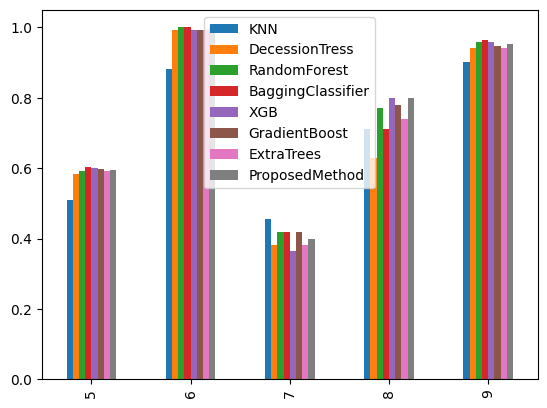

In [ ]:
df_plot = df.iloc[5:, : -2]
df_plot.plot.bar()

<Axes: >

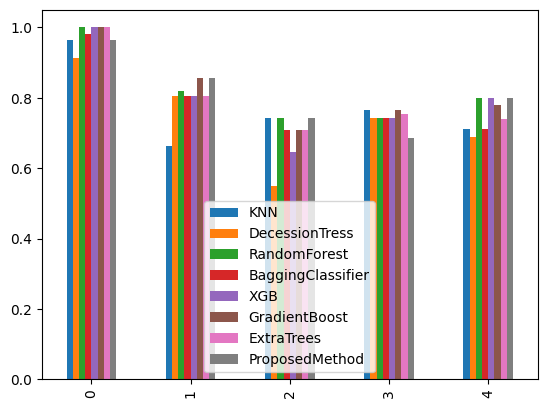

In [ ]:
df_plot = df.iloc[:5, : -2]
df_plot.plot.bar()

### Dataset Characteristics

In [ ]:
names = ['Cancer', 'Diabetic', 'HeartDisease', 'Titanic', 'Netflix', 'CountrySalary', 'Psycology','HousingPrice', 'BangladeshWeather', 'AirbnbRental', 'CreditRisk', 'CarAcceptability']
datasets = [cancerDataset(), diabeticDataset(), heartDiseaseDataset(),titanicDataset(), netflixDataset(), countrySalaryDataset(), psycologyDataset(), housingPriceDataset(), bangladeshWeatherDataset(), airbnbRentalDataset(), creditRiskDataset(), carAcceptabilityDataset()]
output.clear()

for k in range(8, 12):
  X_train, X_validation, X_test, Y_train, Y_validation, Y_test, header, label_names = datasets[k]

  array_val = np.array(Y_train)
  unique = np.unique(array_val)
  types = list(pd.DataFrame(X_train).dtypes)
  array_types = np.array(types)
  unique_types = np.unique(array_types)
  oversample = SMOTE(k_neighbors=1)
  X_train, Y_train = oversample.fit_resample(X_train, Y_train)


  print('-------------------', names[k], '--------------------------')
  print('Total Entries : ', len(X_train)+ len(X_validation) + len(X_test), '\n')
  print('Total Features : ', len(X_train[0]), '\n')
  print('Total Catagories : ', unique, '\n')
  print('Total DataTypes : ',   unique_types, '\n')

  print(Counter(Y_train))
  print(Counter(Y_validation))
  print(Counter(Y_test))

------------------- BangladeshWeather --------------------------
Total Entries :  14740 

Total Features :  26 

Total Catagories :  [0 1 2 3 4 5 6 7 8] 

Total DataTypes :  [dtype('float64')] 

Counter({2: 1547, 1: 1547, 8: 1547, 0: 1547, 6: 1547, 4: 1547, 3: 1547, 5: 1547, 7: 1547})
Counter({2: 381, 1: 118, 4: 12, 0: 6, 6: 3, 5: 2, 8: 2, 7: 1})
Counter({2: 201, 1: 74, 6: 6, 4: 5, 8: 3, 0: 2, 5: 1})
------------------- AirbnbRental --------------------------
Total Entries :  1312 

Total Features :  18 

Total Catagories :  [0 1] 

Total DataTypes :  [dtype('float64')] 

Counter({1: 516, 0: 516})
Counter({0: 126, 1: 54})
Counter({0: 67, 1: 33})
------------------- CreditRisk --------------------------
Total Entries :  1310 

Total Features :  57 

Total Catagories :  [0 1] 

Total DataTypes :  [dtype('float64')] 

Counter({0: 515, 1: 515})
Counter({1: 123, 0: 57})
Counter({1: 62, 0: 38})
------------------- CarAcceptability --------------------------
Total Entries :  4036 

Total Feat

In [ ]:
df_X = pd.DataFrame(X)
df_Y = pd.DataFrame(Y)
df = pd.concat([df_X, df_Y], axis=1)
df.columns= header

Counter({0: 186, 1: 186})
Counter({0: 52, 1: 25})
Counter({0: 30, 1: 13})
